# Author: Tobias

In [2]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import os
import re
import pprint
import pandas as pd
import numpy as np

basepath = Path(os.getcwd())
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    basepath =  Path(os.getcwd())
    print(os.getcwd())
load_dotenv(find_dotenv())

from src.preprocessing.split.train_test_split import train_test_split

In [3]:
logfile_path = basepath / "logs" / "experiment-log.json"
unvalid_logfile_path = basepath / "logs" / "unvalidated-experiment-log.json"
reevaluation_experiments_path = basepath / "logs" / "reevaluation_experiments.json"
unvalid_logfile_path, logfile_path, reevaluation_experiments_path

(PosixPath('/srv/idp-radio-1/logs/unvalidated-experiment-log.json'),
 PosixPath('/srv/idp-radio-1/logs/experiment-log.json'),
 PosixPath('/srv/idp-radio-1/logs/reevaluation_experiments.json'))

In [4]:
def load_experiments(path):
    with open(path, 'r') as f:
                main_data = json.load(f)

    experiments = main_data['experiments']
    experiments_df = pd.DataFrame.from_dict(experiments)
    records_struct = json.loads(experiments_df.to_json(orient="records"))    
    experiments = pd.json_normalize (records_struct) #use pd.io.json
    if "benchmark.train_num_samples" in experiments.columns:
        experiments["benchmark.num_samples_train"].fillna(experiments["benchmark.train_num_samples"], inplace=True)
        experiments["benchmark.num_samples_validation"].fillna(experiments["benchmark.valid_num_samples"], inplace=True)
        experiments["benchmark.num_samples_test"].fillna(experiments["benchmark.test_num_samples"], inplace=True)
    return experiments

def calc_max_auc(df, classes):
    df["history.max_val_auc"] = df["history.val_auc"].apply(lambda x:  max(x) if isinstance(x, list) else -np.inf)
    df["best_epoch_by_val_auc"] = df["history.val_auc"].apply(lambda x:  x.index(max(x)) if isinstance(x, list) else float("nan"))
    
    for classname in classes:
        val_key = "history.val_auc_"+classname
        df["history.best_epoch_val_auc_"+classname] = df.apply(lambda x: x[val_key][int(x["best_epoch_by_val_auc"])] if isinstance(x[val_key], list) else 0, axis=1)
        df["history.max_val_auc_"+classname] = df[val_key].apply(lambda x:  max(x) if isinstance(x, list) else -np.inf)
        df["best_epoch_by_val_auc_"+classname] = df[val_key].apply(lambda x: x.index(max(x)) if isinstance(x, list) else float("nan"))
    
    df = df.sort_values("history.max_val_auc", ascending=False)
    return df

def calc_mean_auc(df, classes):
    val_auc_sum = 0
    test_auc_sum = 0
    for classname in classes:
        val_key = "val_again.auc_"+classname
        test_key = "test_again.auc_"+classname
        val_auc_sum += df[val_key]
        test_auc_sum += df[test_key]
    df["val_again.auc"] = val_auc_sum / len(classes)
    df["test_again.auc"] = test_auc_sum / (len(classes)-1)
    return df

def has_num_classes(df, num_classes, comp=lambda x, y: x==y):
    return comp(df["benchmark.label_columns"].map(len), num_classes)

def has_test_set_size(df, test_set_size):
    return df["benchmark.num_samples_test"] == test_set_size

def is_architecture(df, architecture_name):
    return df["name"].map(lambda x: x.split("_")[0]) == architecture_name

In [96]:
experiments1 = load_experiments(logfile_path)
experiments2 = load_experiments(unvalid_logfile_path)
experiments3 = load_experiments(reevaluation_experiments_path)
experiments = experiments1.append(experiments2)
#experiments = experiments3
experiments = experiments.append(experiments3)
len(experiments)

114

In [6]:
experiments = experiments[has_num_classes(experiments, 12)]
experiments = experiments[has_test_set_size(experiments, 234)]
#experiments = experiments[is_architecture(experiments, "DenseNet121")]
len(experiments)

36

In [7]:
classes = [classname.lower().replace(" ", "_") for classname in experiments.iloc[0]["benchmark.label_columns"]]
experiments = calc_mean_auc(experiments, classes)
experiments = calc_max_auc(experiments, classes)

In [17]:
for col in experiments.columns:
    print(col)

id
name
filename
version
description
classification_report
history.loss
history.auc
history.precision
history.recall
history.f2_score
history.binary_accuracy
history.accuracy_cardiomegaly
history.accuracy_edema
history.accuracy_consolidation
history.accuracy_atelectasis
history.accuracy_pleural_effusion
history.auc_cardiomegaly
history.auc_edema
history.auc_consolidation
history.auc_atelectasis
history.auc_pleural_effusion
history.precision_cardiomegaly
history.precision_edema
history.precision_consolidation
history.precision_atelectasis
history.precision_pleural_effusion
history.recall_cardiomegaly
history.recall_edema
history.recall_consolidation
history.recall_atelectasis
history.recall_pleural_effusion
history.f2_score_cardiomegaly
history.f2_score_edema
history.f2_score_consolidation
history.f2_score_atelectasis
history.f2_score_pleural_effusion
history.learning rate
history.val_loss
history.val_auc
history.val_precision
history.val_recall
history.val_f2_score
history.val_binary_a

In [93]:
df = experiments[['name', 'val_again.auc', 'test_again.auc', 'benchmark.augmentation', 'benchmark.loss', 'benchmark.optimizer', 'benchmark.crop']]
df['benchmark.augmentation'] = df['benchmark.augmentation'].fillna('no augmentation')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


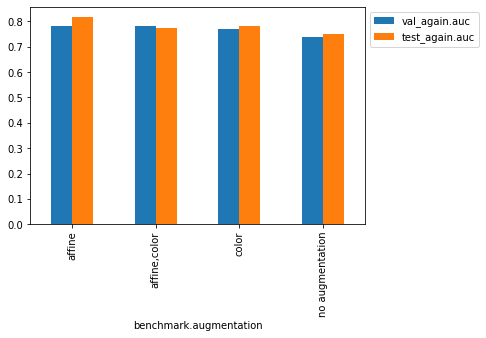

In [94]:
df.groupby('benchmark.augmentation', ).mean().plot(kind="bar").legend(bbox_to_anchor=(1, 1))

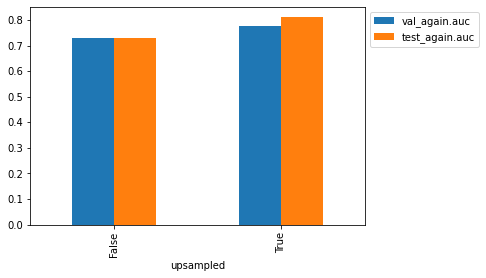

In [78]:
df2 = df.copy()
df2['upsampled'] = df.name.str.match(r'.*Upsampled')
df2.groupby('upsampled', ).mean().plot(kind="bar").legend(bbox_to_anchor=(1, 1))

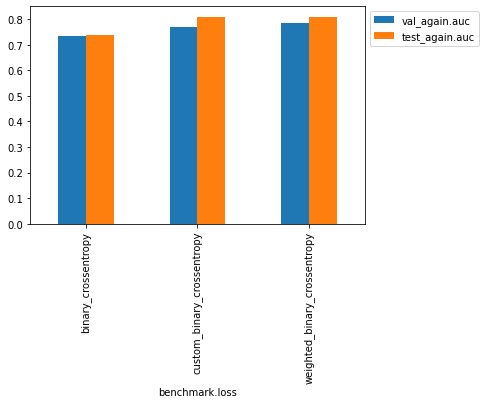

In [79]:
df.groupby('benchmark.loss', ).mean().plot(kind="bar").legend(bbox_to_anchor=(1, 1))

In [80]:
df.groupby('benchmark.optimizer').mean()

,val_again.auc,test_again.auc,benchmark.crop
benchmark.optimizer,,,
Adam,0.757593,0.785210,False
SGD,0.774102,0.798998,False


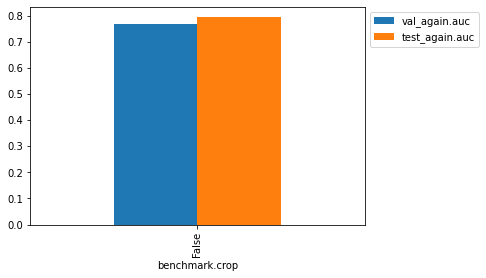

In [81]:
df.groupby('benchmark.crop', ).mean().plot(kind="bar").legend(bbox_to_anchor=(1, 1))

In [68]:
best_epxeriment = experiments.iloc[experiments["val_again.auc"].argmax()]
for col in ["id", "name", "val_again.auc", "val.auc", "test_again.auc", "test.auc", ]:
    print(col, "-", best_epxeriment[col])

id - bd5c2e9a-e9ec-11ea-ae3a-0242ac110005
name - DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled
val_again.auc - 0.7945824513833332
val.auc - 0.7945824265
test_again.auc - 0.8603749329272727
test.auc - 0.7886769772


In [70]:
best_epxeriment = experiments.iloc[experiments["test_again.auc"].argmax()]
auc = 0
for col in ["id", "name", "val_again.auc", "val.auc", "test_again.auc", "test.auc", ]:
    print(col, "-", best_epxeriment[col])
for classname in classes:
    print("test", classname, best_epxeriment["test.auc_"+classname])
    print("test", classname, best_epxeriment["test_again.auc_"+classname])
    auc += best_epxeriment["test_again.auc_"+classname]

id - bd5c2e9a-e9ec-11ea-ae3a-0242ac110005
name - DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled
val_again.auc - 0.7945824513833332
val.auc - 0.7945824265
test_again.auc - 0.8603749329272727
test.auc - 0.7886769772
test enlarged_cardiomediastinum 0.5304219723
test enlarged_cardiomediastinum 0.5304219723
test cardiomegaly 0.7865875959
test cardiomegaly 0.7865875959
test lung_opacity 0.9126616716
test lung_opacity 0.9126616716
test lung_lesion 0.9828326702
test lung_lesion 0.9828326702
test edema 0.9298648238
test edema 0.9298648238
test consolidation 0.9208502769
test consolidation 0.9208502769
test pneumonia 0.8282632828
test pneumonia 0.8282632828
test atelectasis 0.8260958195
test atelectasis 0.8260958195
test pneumothorax 0.8451327085
test pneumothorax 0.8451327085
test pleural_effusion 0.9185807705
test pleural_effusion 0.9185807705
test pleural_other 0.9828326702
test pleural_other 0.9828326702
test fracture 0.0
test fr

In [73]:
auc / (len(classes) - 1)

0.8603749329272727

In [74]:
best_perclass = {}
splitname= "test"
for classname in classes:
    if splitname == "test" and classname=="fracture": 
        continue
    row_num = experiments[splitname+"_again.auc_"+classname].argmax()
    tup = (classname, experiments.iloc[row_num][splitname+"_again.auc_"+classname])
    if row_num in best_perclass.keys():
        best_perclass[row_num].append(tup)
    else:
        best_perclass[row_num]=[tup]
best_perclass, [experiments.iloc[row]["id"] for row in best_perclass.keys()]

({24: [('enlarged_cardiomediastinum', 0.6889541149)],
  28: [('cardiomegaly', 0.8226435184)],
  35: [('lung_opacity', 0.925889194)],
  11: [('lung_lesion', 0.9957081676), ('edema', 0.9384480119)],
  10: [('consolidation', 0.9481381178)],
  14: [('pneumonia', 0.8697455525)],
  1: [('atelectasis', 0.8820616603)],
  17: [('pneumothorax', 0.8708517551)],
  4: [('pleural_effusion', 0.9314505458)],
  16: [('pleural_other', 1.0)]},
 ['1262eecc-e490-11ea-a3de-0242ac110005',
  '4267e786-e2dc-11ea-a072-0242ac110005',
  '03479e56-ee90-11ea-b021-0242ac110002',
  'fc098932-e58f-11ea-8d19-0242ac110005',
  'ac1da21e-e47c-11ea-ad88-0242ac110005',
  'a99f1906-e4a3-11ea-87a3-0242ac110005',
  'ba5364e6-e949-11ea-87eb-0242ac110005',
  'c55ed5c6-e879-11ea-9a58-0242ac110005',
  'f5345e7e-e603-11ea-b461-0242ac110005',
  '653d264a-ee44-11ea-bcb1-0242ac110002'])

In [75]:
best_perclass_models = {}
for classname in classes:
    best_key = "history.best_epoch_val_auc_"+classname
    max_key = "history.max_val_auc_"+classname
    best_epoch_key = "best_epoch_by_val_auc_"+classname
    best_model = experiments.sort_values(best_key, ascending=False).iloc[0]
    model_name = best_model["name"]
    stats = {"best_"+classname:best_model[best_key],
            "max_"+classname:best_model[max_key],
            "best_index":best_model["best_epoch_by_val_auc"],
            "max_index_"+classname:best_model[best_epoch_key]}
    
    if not model_name in best_perclass_models.keys():
        best_perclass_models[model_name] = [stats]
    else:
        best_perclass_models[model_name] += [stats]
    
    #print ("\nname", model_name)
    #print (key, best_model[key])
    #print (best_epoch_key, best_model[best_epoch_key])
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(best_perclass_models)
best_ids = []
for best_name in best_perclass_models.keys():
    print("name:", best_name)
    experiment_id =  experiments[experiments["name"] == best_name]["id"]
    print("id:", experiment_id)
    best_ids.append(experiment_id.iloc[0])
best_ids   

{   'DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled': [   {   'best_edema': 0.8598303795,
                                                                                                                             'best_index': 2.0,
                                                                                                                             'max_edema': 0.8598303795,
                                                                                                                             'max_index_edema': 2.0},
                                                                                                                         {   'best_fracture': 0.8078253865,
                                                                                                                             'best_index': 2.0,
                                                                                                     

['b57e5750-e66a-11ea-bb5e-0242ac110005',
 '74d8220a-e6c2-11ea-b084-0242ac110005',
 'e506d8f0-ea0f-11ea-8dbb-0242ac110005',
 '5dcb7ecc-e4e2-11ea-96c6-0242ac110005',
 'bd5c2e9a-e9ec-11ea-ae3a-0242ac110005',
 '7f0b1972-e5e5-11ea-a85b-0242ac110005',
 'ba5364e6-e949-11ea-87eb-0242ac110005']

In [70]:
experiments.iloc[52][class_columns]

test_again.auc_enlarged_cardiomediastinum     0.547743
test_again.auc_cardiomegaly                   0.810551
test_again.auc_lung_opacity                    0.90377
test_again.auc_lung_lesion                   0.0772532
test_again.auc_edema                          0.893063
test_again.auc_consolidation                  0.885421
test_again.auc_pneumonia                      0.668695
test_again.auc_atelectasis                     0.76733
test_again.auc_pneumothorax                   0.739215
test_again.auc_pleural_effusion               0.915989
test_again.auc_pleural_other                  0.871245
test_again.auc_fracture                              0
Name: 2, dtype: object

In [89]:
class_columns = []
for classname in classes:
    key = "test_again.auc_"+classname
    if classname != "fracture":
        class_columns += [key]
    experiments[key].fillna(experiments["test.auc_"+classname], inplace=True)
experiments["test_again.auc"] = experiments[class_columns].mean(axis=1)
experiments.drop_duplicates(["name", *class_columns], inplace=True)

In [90]:
for index, exp in experiments.sort_values("test_again.auc", ascending=False).head(8).iterrows():
    #print(exp)
    print("name", exp["name"])
    print("test.auc", exp["test.auc"])
    print("test_again.auc", exp["test_again.auc"])
    print("history.max_val_auc", exp["history.max_val_auc"])
#experiments["history.max_val_auc"]
#df.sort_values("history.max_val_auc", ascending=False)

name DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled
test.auc 0.7886769772
test_again.auc 0.8603749329272727
history.max_val_auc 0.7946436405
name InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled
test.auc 0.7768623233
test_again.auc 0.8474861112636364
history.max_val_auc 0.7867934704
name DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled
test.auc 0.7765927315
test_again.auc 0.8471921357363636
history.max_val_auc 0.777176559
name DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_gb_hist_U75_D256_DS9505_2LR4_LF5_Adam_Upsampled
test.auc 0.7749938369
test_again.auc 0.8454478274545455
history.max_val_auc 0.7840108871
name DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U66_D256_DS9505_2LR1_LF5_SGD_Upsampled_1
test.auc 0.7743986249
test_again.auc 0.8447984944636364
history.max_val_auc 0.7805803418
name DenseNet121_Chexper

In [92]:
def print_report(x):
    print(x["name"])
    print("history.val_auc_max: ", x["history.val_auc_max"])
    print(x.classification_report) 
    print("\n\n")
    

In [34]:
for _, exp in experiments.sort_values("test_again.auc", ascending=False).head(8).iterrows():
    for col in ["id", "name", "val_again.auc", "val.auc", "test_again.auc", "test.auc", ]:
        print(col, "-", exp[col])
    print("\n")

id - bd5c2e9a-e9ec-11ea-ae3a-0242ac110005
name - DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled
val_again.auc - 0.7945824513833332
val.auc - 0.7945824265
test_again.auc - 0.8603749329272727
test.auc - 0.7886769772


id - bca75ad8-e6f4-11ea-a90b-0242ac110005
name - InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled
val_again.auc - 0.7853282491416667
val.auc - 0.785330832
test_again.auc - 0.8474861112636364
test.auc - 0.7768623233


id - 1262eecc-e490-11ea-a3de-0242ac110005
name - DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled
val_again.auc - 0.7771773586583333
val.auc - 0.777176559
test_again.auc - 0.8471921357363636
test.auc - 0.7765927315


id - 3ecd1de0-e619-11ea-8544-0242ac110005
name - DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_gb_hist_U75_D256_DS9505_2LR4_LF5_Adam_Upsampled
val_again.auc - 0.78401095668

Augmentation:
- ohne Augmentations bessere Ergebnisse
- mit Augmentation höherer Val AUC aber niedrigerer Test AUC
- im Test Set sind alle Bilder zentriert und ohne Rand, ist deswegen die Testperformance schlechter?
- auch in der JF Healthcare Implementierung hat uns Augmentation nichts gebracht

Best Metric:
- wir brauchen ein Model OHNE Affine Transformation das mit CWBCE und WBCE trainiert wurde
- haben momentan überall BCE, wo CWBCE und WBCE benutzt wurde haben wir das nur mit Augmentation gemacht, was wahrscheinlich die Performance verschlechtert
- no comparison possible

Upsampling:
- clearly gives better performance, see DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 & DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_1

Uncertainty Encodings:
- no comparison possible

Models to train: 
- DenseNet121_Chexpert_BCE_E3_B32_C0_N12_CLASSBASED_D256_DS9505_2LR1_LF5_SGD_Upsampled_1
- decide if class based encodings work better
- based on that then train:
- DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_?????_D256_DS9505_2LR1_LF5_SGD_Upsampled_1
- DenseNet121_Chexpert_CWBCE_E3_B32_C0_N12_?????_D256_DS9505_2LR1_LF5_SGD_Upsampled_1
- lastly, we could still try training the best model we find for 5 Epochs because all papers do that

